In [62]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import albumentations as albu
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

In [63]:
# parameters for data
height = 224
width = 224
channels = 3
input_shape = (height, width, channels)
n_classes = 100

# parameters for optimizers
lr = 1e-3

# Parameters for training
epochs = 25
batch_size = 8

# parameters for callback functions
es_patience = 10
rlrop_patience = 5
decay_rate = 0.5

In [64]:
(X, y), (X_test, y_test) = cifar100.load_data()

print("The shape of X_train : ", X.shape)
print("The shape of X_test : ", X_test.shape)

fine_label_list =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
                    'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
                    'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
                    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
                    'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
                    'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 
                    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
                    'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
                    'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

The shape of X_train :  (50000, 32, 32, 3)
The shape of X_test :  (10000, 32, 32, 3)


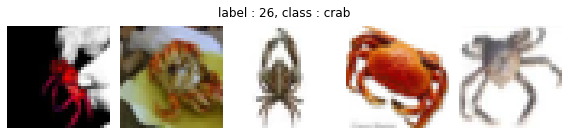

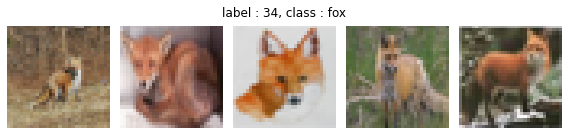

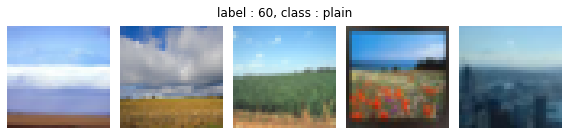

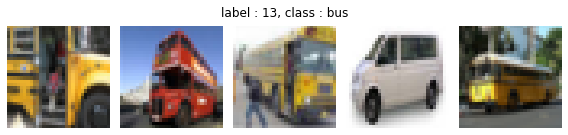

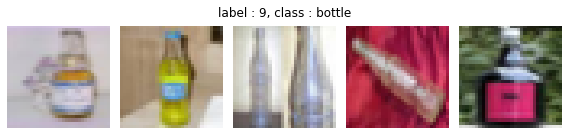

In [65]:
class_plotted = np.random.choice(range(n_classes), 5, replace = False)
for i in range(len(class_plotted)):
    image_samples = X[y.reshape(-1) == class_plotted[i]][:5]
    fig, ax = plt.subplots(nrows = 1, ncols = 5,figsize = (8,8))
    fig.suptitle("label : %d, class : %s" % (class_plotted[i], fine_label_list[class_plotted[i]]), y = .6)
    for j in range(5):
        ax[j].imshow(image_samples[j])
        ax[j].axis('off')  
    fig.tight_layout()
plt.show()

In [66]:
# Spliting the training data into a training data and a validation data.
st = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 1)
for train_index, val_index in st.split(X, y):
    X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]
    
print("The number of training data : ", X_train.shape[0])
print("The number of validation data : ", X_val.shape[0])

del X, y

The number of training data :  40000
The number of validation data :  10000


In [67]:
def np_resize(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)

In [68]:
class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for keras'
    def __init__(self, images , labels = None, mode = 'fit', batch_size = batch_size,
                 dim = (height, width), channels = channels, n_classes = n_classes,
                 shuffle = True, augment = False):
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))
        
    def __getitem__(self, index):
        'Generate one batch of data'
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # =========================================================== #
        # Generate mini-batch of X
        # =========================================================== #
        X = np.empty((self.batch_size, *self.dim, self.channels))
        for i, ID in enumerate(batch_indexes):
            # Generate a preprocessed image
            img = self.images[ID]
            img = img.astype(np.float32) 
            img = np_resize(img, self.dim)
            X[i] = img
            
        
        # =========================================================== #
        # Generate mini-batch of y
        # =========================================================== #
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            y = to_categorical(y, n_classes)
            '''
            y = np.zeros((self.batch_size, self.n_classes), dtype = np.uint8)
            for i, ID in enumerate(batch_indexes):
                # one hot encoded label
                y[i, self.labels[ID]] = 1
            '''
            # Augmentation should only be implemented in the training part.
            if self.augment == True:
                X = self.__augment_batch(X)                
            
            return X,y
        
        elif self.mode == 'predict':
            return X       
        
        else:
            raise AttributeError('The mode parameters should be set to "fit" or "predict"')
            
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p = 0.5),
                                    albu.VerticalFlip(p = 0.5),
                                    albu.GridDistortion(p = 0.2),
                                    albu.ElasticTransform(p = 0.2)])
        
        return composition(image = img)['image']
        
    
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
            
        return img_batch


In [69]:
train_generator = DataGenerator(X_train, y_train, augment = True)
valid_generator = DataGenerator(X_val, y_val, augment = False)

In [70]:
# import efficientnet.keras as efn 
from keras.applications.efficientnet import EfficientNetB4


efnb0 = tensorflow.keras.applications.EfficientNetB4(weights = 'imagenet', include_top = False, classes = n_classes, input_shape = input_shape)
# efnb0 = tensorflow.keras.applications.MobileNetV2(weights = 'imagenet', include_top = False, classes = n_classes, input_shape = input_shape)
efnb0.trainable = False

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation = 'softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 7, 7, 1792)       17673823  
                                                                 
 global_average_pooling2d_6   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 1792)              0         
                                                                 
 dense_6 (Dense)             (None, 100)               179300    
                                                                 
Total params: 17,853,123
Trainable params: 179,300
Non-trainable params: 17,673,823
_________________________________________________________________


In [71]:
sgd = SGD(lr = lr, momentum = 0.9, nesterov = True)
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = es_patience, restore_best_weights = True, verbose = 1)
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = rlrop_patience, 
                        factor = decay_rate, min_lr = 1e-6, verbose = 1)

c:\ProgramData\Miniconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [72]:
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['acc'])


In [73]:
hist = model.fit(train_generator,
                 validation_data = valid_generator, 
                 epochs = epochs, 
                 verbose = 1, 
                 callbacks = [es, rlrop])

Epoch 1/25
5000/5000 [==============================] - 276s 54ms/step - loss: 2.9175 - acc: 0.3741 - val_loss: 1.6164 - val_acc: 0.6382 - lr: 0.0010
Epoch 2/25
5000/5000 [==============================] - 264s 53ms/step - loss: 2.0068 - acc: 0.5014 - val_loss: 1.3085 - val_acc: 0.6694 - lr: 0.0010
Epoch 3/25
5000/5000 [==============================] - 267s 53ms/step - loss: 1.8137 - acc: 0.5338 - val_loss: 1.2013 - val_acc: 0.6846 - lr: 0.0010
Epoch 4/25
5000/5000 [==============================] - 260s 52ms/step - loss: 1.7153 - acc: 0.5538 - val_loss: 1.1444 - val_acc: 0.6924 - lr: 0.0010
Epoch 5/25
4802/5000 [===========================>..] - ETA: 8s - loss: 1.6577 - acc: 0.5620

KeyboardInterrupt: 